# Prolog (Imports, setting up)

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pillow
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow
!pip install tensorflow-datasets
!pip install tensorflow-addons
!pip install tqdm
!pip install pandas
!pip install opencv-python



import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils.class_weight import compute_class_weight
import shutil
from google.colab import drive
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
import random
import seaborn as sns
import pandas as pd

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam


from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import time

from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import SGD

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [ ]:
!cat /proc/meminfo

MemTotal:       175166496 kB
MemFree:        169908284 kB
MemAvailable:   172161176 kB
Buffers:          164784 kB
Cached:          3325776 kB
SwapCached:            0 kB
Active:           567952 kB
Inactive:        4014516 kB
Active(anon):       1504 kB
Inactive(anon):  1092628 kB
Active(file):     566448 kB
Inactive(file):  2921888 kB
Unevictable:           8 kB
Mlocked:               8 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              3220 kB
Writeback:             0 kB
AnonPages:       1092108 kB
Mapped:           885884 kB
Shmem:              2160 kB
KReclaimable:     233832 kB
Slab:             308276 kB
SReclaimable:     233832 kB
SUnreclaim:        74444 kB
KernelStack:       10080 kB
PageTables:        17888 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    87583248 kB
Committed_AS:    5205168 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       99792 kB
VmallocChunk: 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# BASE_DIR = "/Users/maiasalti/Downloads/chest_xray/chest_xray"

In [ ]:
BASE_DIR = '/content/drive/MyDrive/Math_156_Project/chest_xray'
print(os.listdir(BASE_DIR))

normal_train_dir = os.path.join(BASE_DIR, "train", "NORMAL")
pneumonia_train_dir = os.path.join(BASE_DIR, "train", "PNEUMONIA")

['train', 'val', 'test']


In [ ]:
train_dir = os.path.join(BASE_DIR, "train")
val_dir = os.path.join(BASE_DIR, "val")
test_dir = os.path.join(BASE_DIR, "test")

In [ ]:
import random
import numpy as np
import tensorflow as tf

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# EDA

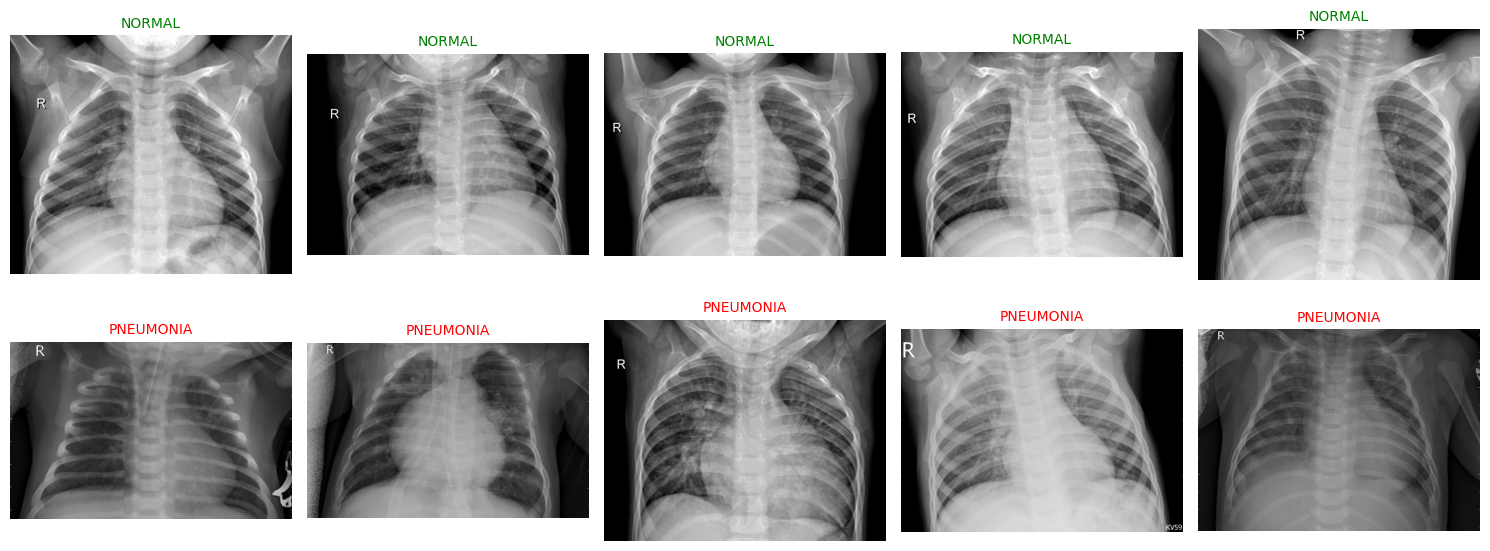

In [ ]:
# Displaying sample images from each class

normal_images = [img for img in os.listdir(normal_train_dir) if img.endswith('.jpeg')][:5]
pneumonia_images = [img for img in os.listdir(pneumonia_train_dir) if img.endswith('.jpeg')][:5]

# Create a 2x5 subplot grid for visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot NORMAL images
for i in range(5):
    img = Image.open(os.path.join(normal_train_dir, normal_images[i]))
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title('NORMAL', fontsize=10, color='green')
    axes[0, i].axis('off')

# Plot PNEUMONIA images
for i in range(5):
    img = Image.open(os.path.join(pneumonia_train_dir, pneumonia_images[i]))
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title('PNEUMONIA', fontsize=10, color='red')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Analyzing image dimensions (width/height) - within training

all_widths = []
all_heights = []

for img_name in os.listdir(normal_train_dir):
    if img_name.endswith('.jpeg'):
        img = Image.open(os.path.join(normal_train_dir, img_name))
        all_widths.append(img.width)
        all_heights.append(img.height)

for img_name in os.listdir(pneumonia_train_dir):
    if img_name.endswith('.jpeg'):
        img = Image.open(os.path.join(pneumonia_train_dir, img_name))
        all_widths.append(img.width)
        all_heights.append(img.height)

print("Image Dimensions:")
print(f"\nWidth:")
print(f"Min: {min(all_widths)} pixels")
print(f"Max: {max(all_widths)} pixels")
print(f"Mean: {np.mean(all_widths):.1f} pixels")
print(f"Median: {np.median(all_widths):.1f} pixels")


print(f"\nHeight:")
print(f"Min: {min(all_heights)} pixels")
print(f"Max: {max(all_heights)} pixels")
print(f"Mean: {np.mean(all_heights):.1f} pixels")
print(f"Median: {np.median(all_widths):.1f} pixels")



Image Dimensions:

Width:
Min: 384 pixels
Max: 2916 pixels
Mean: 1320.7 pixels
Median: 1284.0 pixels

Height:
Min: 127 pixels
Max: 2663 pixels
Mean: 968.2 pixels
Median: 1284.0 pixels


In [ ]:
# Checking Class Distributions within training

normal_count = len([img for img in os.listdir(normal_train_dir) if
img.endswith('.jpeg')])

pneumonia_count = len([img for img in os.listdir(pneumonia_train_dir) if
img.endswith('.jpeg')])

total = normal_count + pneumonia_count
normal_pct = (normal_count / total) * 100
pneumonia_pct = (pneumonia_count / total) * 100

print("Class Distribution (Training Set):")
print(f"\nNORMAL: {normal_count:4d} images ({normal_pct:.1f}%)")
print(f"PNEUMONIA: {pneumonia_count:4d} images ({pneumonia_pct:.1f}%)")
print(f"TOTAL: {total:4d} images")
print(f"Ratio: {pneumonia_count/normal_count:.2f}:1 (Pneumonia:Normal)")

Class Distribution (Training Set):

NORMAL: 1349 images (25.8%)
PNEUMONIA: 3883 images (74.2%)
TOTAL: 5232 images
Ratio: 2.88:1 (Pneumonia:Normal)


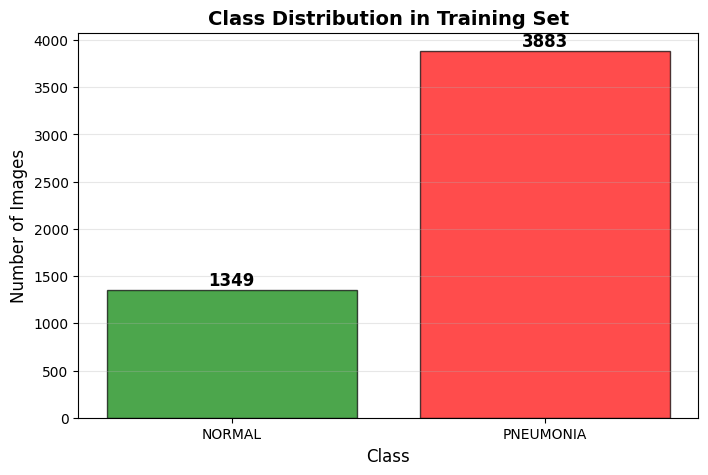

In [ ]:
# Visualizing class distributions (showing imbalance)
classes = ['NORMAL', 'PNEUMONIA']
counts = [normal_count, pneumonia_count]
colors = ['green', 'red']

plt.figure(figsize=(8, 5))
plt.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black')
plt.title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Class', fontsize=12)


for i, count in enumerate(counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=12,
fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

This shows that the training set classes are heavily imbalanced. As such, we will have to take this into consideration when creating our model/doing some augmentation.

In [ ]:

# Helper function to count images
def count_images(folder):
    normal_path = os.path.join(folder, "NORMAL")
    pneumonia_path = os.path.join(folder, "PNEUMONIA")

    normal_count = len([img for img in os.listdir(normal_path) if img.endswith('.jpeg')])
    pneumonia_count = len([img for img in os.listdir(pneumonia_path) if img.endswith('.jpeg')])
    total = normal_count + pneumonia_count

    return normal_count, pneumonia_count, total

In [ ]:
# Looking deeper into image counts on data-split level


# Count for each split
train_normal, train_pneu, train_total = count_images(train_dir)
val_normal, val_pneu, val_total = count_images(val_dir)
test_normal, test_pneu, test_total = count_images(test_dir)

# Print results neatly
print("Dataset Split Summary")
print(f"\nTraining Set: NORMAL={train_normal:4d}, PNEUMONIA={train_pneu:4d}, TOTAL={train_total:5d}")
print(f"Validation Set: NORMAL={val_normal:4d}, PNEUMONIA={val_pneu:4d}, TOTAL={val_total:5d}")
print(f"Test Set: NORMAL={test_normal:4d}, PNEUMONIA={test_pneu:4d}, TOTAL={test_total:5d}")
print(f"Grand Total: {train_total + val_total + test_total} images")


Dataset Split Summary

Training Set: NORMAL=1349, PNEUMONIA=3883, TOTAL= 5232
Validation Set: NORMAL=   0, PNEUMONIA=   0, TOTAL=    0
Test Set: NORMAL= 234, PNEUMONIA= 390, TOTAL=  624
Grand Total: 5856 images


We can see that the validation dataset is extremely tiny. Overall, not only is this an imbalanced dataset, but it is also not properly split up. This is something that we will fix in the preprocessing step

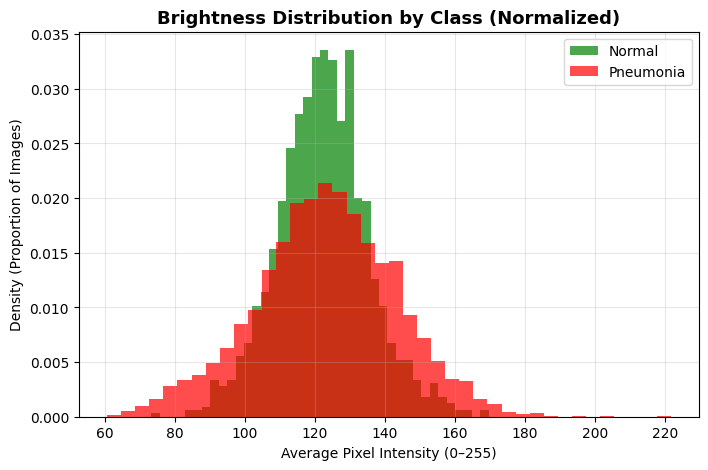

In [ ]:
# Looking into brightness/intensity

def compute_avg_intensity(folder_path):
    intensities = []
    for img_name in os.listdir(folder_path):
        if img_name.endswith('.jpeg'):
            img = Image.open(os.path.join(folder_path, img_name)).convert('L')  # grayscale - just in case
            intensities.append(np.mean(img))
    return intensities

# Compute per-image brightness for each class
normal_brightness = compute_avg_intensity(normal_train_dir)
pneumonia_brightness = compute_avg_intensity(pneumonia_train_dir)

# Counts version of the histogram
# plt.figure(figsize=(8,5))
# plt.hist(normal_brightness, bins=40, alpha=0.7, color='green', label='Normal')
# plt.hist(pneumonia_brightness, bins=40, alpha=0.7, color='red', label='Pneumonia')
# plt.title('Brightness Distribution by Class', fontsize=13)
# plt.xlabel('Average Pixel Intensity (0–255)')
# plt.ylabel('Number of Images')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()

# Normalized version
plt.figure(figsize=(8,5))
plt.hist(normal_brightness, bins=40, alpha=0.7, color='green', label='Normal', density=True)
plt.hist(pneumonia_brightness, bins=40, alpha=0.7, color='red', label='Pneumonia', density=True)
plt.title('Brightness Distribution by Class (Normalized)', fontsize=13, fontweight='bold')
plt.xlabel('Average Pixel Intensity (0–255)')
plt.ylabel('Density (Proportion of Images)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Brightness is the average intensity/average pixel vaue of the image. In grayscale - goes from 0 (black) to 255 (white). This shows that pneumonia images show greater variability in average brightness, whereas normal images are much more consistent. There is a large overlap in the middle region (shows that brightness alone cannot be used to separate the classes)

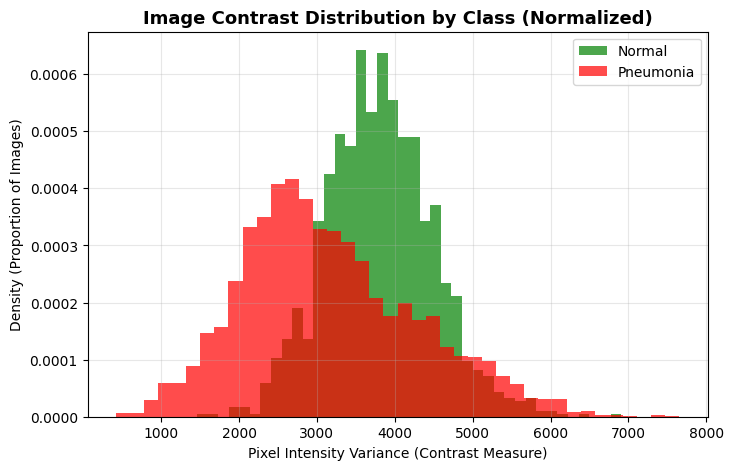

In [ ]:
# Image contrast/sharpness

def compute_contrast(folder_path):
    contrasts = []
    for img_name in os.listdir(folder_path):
        if img_name.endswith('.jpeg'):
            img = Image.open(os.path.join(folder_path, img_name)).convert('L')
            arr = np.array(img)
            contrasts.append(np.var(arr))  # higher variance = higher contrast
    return contrasts

# Compute contrast for both classes
normal_contrast = compute_contrast(normal_train_dir)
pneumonia_contrast = compute_contrast(pneumonia_train_dir)

# Counts version of teh histogram
# plt.figure(figsize=(8,5))
# plt.hist(normal_contrast, bins=40, alpha=0.7, color='green', label='Normal')
# plt.hist(pneumonia_contrast, bins=40, alpha=0.7, color='red', label='Pneumonia')
# plt.title('Image Contrast Distribution by Class', fontsize=13, fontweight='bold')
# plt.xlabel('Pixel Intensity Variance')
# plt.ylabel('Number of Images')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()

# Normalized version
plt.figure(figsize=(8,5))

plt.hist(normal_contrast, bins=40, alpha=0.7, color='green', label='Normal', density=True)
plt.hist(pneumonia_contrast, bins=40, alpha=0.7, color='red', label='Pneumonia', density=True)

plt.title('Image Contrast Distribution by Class (Normalized)', fontsize=13, fontweight='bold')
plt.xlabel('Pixel Intensity Variance (Contrast Measure)')
plt.ylabel('Density (Proportion of Images)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Contrast measures variation in pixel intensity (variance/std dev of pixel intensities). Overall, we can see that there is a huge difference here between contrast. Pneumonia's average contrast is lower than that of normal x-ray images. This can be interpreted as saying that the pneumonia x-rays are generally less sharp, making the image appear more hazy or cloudy. We can also see that the data for Pneumonia is also skewed right, showing that while many pneumonia images have low contrast, a smaller subset of them have unusually higher variance.

# Data preprocessing

Primarily, the first issue that arises is that currently, the validation set only has 16 samples. This is extremely small, which would lead to noisy outcomes, impacting our undrestanding of a proper, generalizable model. Our solution to this is to primarily, merge the validation data back into training, and then use cross-validation. **Later: add in # of folds we use, and how it was impacted by runtime**

In [ ]:
train_dir = os.path.join(BASE_DIR, "train")
val_dir = os.path.join(BASE_DIR, "val")

for cls in ['NORMAL', 'PNEUMONIA']:
    src_dir = os.path.join(val_dir, cls)
    dest_dir = os.path.join(train_dir, cls)

    for img in os.listdir(src_dir):
        shutil.move(os.path.join(src_dir, img), os.path.join(dest_dir, img))


In [ ]:
# Double checking counts
train_normal, train_pneu, train_total = count_images(train_dir)
val_normal, val_pneu, val_total = count_images(val_dir)

print(f"Training Set: NORMAL={train_normal:4d}, PNEUMONIA={train_pneu:4d}, TOTAL={train_total:5d}")
print(f"Validation Set: NORMAL={val_normal:4d}, PNEUMONIA={val_pneu:4d}, TOTAL={val_total:5d}")

Training Set: NORMAL=1349, PNEUMONIA=3883, TOTAL= 5232
Validation Set: NORMAL=   0, PNEUMONIA=   0, TOTAL=    0


ResNet expects all images to be of shape (224, 224, 3). This means that we have to resize all our images to be of size 224 x 224 pixels. Furthermore, since our dataset consists of grayscale X-rays, we must convert them to RGB format to amtch ResNet's expected 3-channel input. We will use Keras and its ImageDataGenerator to handle preprocessing/augmentation. Pixel values will be rescaled/standardized using ImageNet normalization, rather than just [0,1] scaling because this ensures that our input data follows the same distribution that the ResNet50 images were trained on originally. In order to help our model generalize better given that we have a small dataset, we will apply data augmentation in two ways. First, we will use on-the-fly augmentation during training (random rotations/zooms/brightness shifts) to allow the model to see different variations of the training images. If needed, we will also add bootstrapped augmented copies to the Normal class (which is a minority) prior to training, which would help us reduce the class imbalance we see. Lastly, during model training, we will use class weights that are calculated in the preprocessing stage to further address the imbalance between Normal and Pneumonia samples.

In [ ]:
# Results show that there are dimension and class imbalances

# Resizing + Data Augmentation:

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, # ImageNet normalization
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = False,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# data generators

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# train_generator = train_datagen.flow_from_directory(
#     os.path.join(BASE_DIR, 'train'),
#     target_size = IMG_SIZE,
#     batch_size = BATCH_SIZE,
#     class_mode = 'binary',
#     color_mode = 'rgb',
#     shuffle=True)

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False ,
    subset='validation',
    seed=SEED
)


test_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, 'test'),
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle=False,
    seed=SEED
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
images, labels = next(train_generator)
print(f"Batch shape: {images.shape}")

Batch shape: (32, 224, 224, 3)


In [ ]:
from collections import Counter

def print_dataset_stats(generator, name):
    labels = generator.classes  # array of 0/1 labels
    class_names = list(generator.class_indices.keys())
    counts = Counter(labels)
    print(f"--- {name} ---")
    for i, count in counts.items():
        print(f"{class_names[i]}: {count}")
    print(f"Total: {len(labels)}\n")

# Check train, validation, test
print_dataset_stats(train_generator, "Train Set")
print_dataset_stats(val_generator, "Validation Set")
print_dataset_stats(test_generator, "Test Set")

--- Train Set ---
NORMAL: 1080
PNEUMONIA: 3107
Total: 4187

--- Validation Set ---
NORMAL: 269
PNEUMONIA: 776
Total: 1045

--- Test Set ---
NORMAL: 234
PNEUMONIA: 390
Total: 624



In [ ]:
# IF NECESSARY: Additional Augmented Normal photos added in in a bootstrap-like manner

# Paths
# normal_dir = os.path.join(BASE_DIR, 'train', 'NORMAL')
# augmented_dir = os.path.join(BASE_DIR, 'train', 'NORMAL_AUGMENTED')

# # Create a temporary folder for augmented copies
# os.makedirs(augmented_dir, exist_ok=True)

# # Define light augmentation
# augmenter = ImageDataGenerator(
#     rotation_range=15,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
# )

# # Randomly choose some Normal images to augment
# num_to_augment = 500   # change if you want more or fewer
# sample_images = random.sample(os.listdir(normal_dir), min(num_to_augment, len(os.listdir(normal_dir))))

# for img_name in sample_images:
#     img_path = os.path.join(normal_dir, img_name)
#     img = load_img(img_path)
#     x = img_to_array(img)
#     x = np.expand_dims(x, axis=0)

#     # generate one augmented image per original
#     for batch in augmenter.flow(x, batch_size=1, save_to_dir=augmented_dir,
#                                 save_prefix='aug', save_format='jpeg'):
#         break

# # Move augmented images back into NORMAL folder
# for img in os.listdir(augmented_dir):
#     shutil.move(os.path.join(augmented_dir, img), os.path.join(normal_dir, img))

# # Remove the temporary augmented directory (optional cleanup)
# os.rmdir(augmented_dir)

In [ ]:
# Class weights - which we will use in creating the next baseline step


# Get class indices (0 = Normal, 1 = Pneumonia)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


# Creating baseline

We first load ResNet50, which is pretrained on ImageNet, wihtout its top layer os that we can add in our own binary classifier instead. We also freeze all ResNet layers from updating during training because this is our abseline model, and we are trying to keep our pretrained weights. This helps us with reducing computation as well as preventing overfitting.

In [ ]:
# Load ResNet50 without the top layer
base_model = ResNet50(
    weights='imagenet',
    include_top=False,        # remove default classifier
    input_shape=(224, 224, 3) # match resized images
)

base_model._name = "resnet50_backbone"
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

print(f"Number of layers in base model: {len(base_model.layers)}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Number of layers in base model: 175


Now, we are going to create our neural network base. We first use GlobalAveragePooling in order to reduce the number of parameters (by collapsing spatial dimensions) and thus decrease the risk of overfitting. This also helps the model capture lung-wide features rather than focusing only on very specific regions. We then add a fully connected layer with 128 neurons and apply a ReLU activation to introduce non-linearity (allowing the model to learn more complex decision boundaries). Incorporating dropout also allows us to further improve our generalization by randomly disabling some neurons during training. We add a sigmoid output, which is necessary for binary classification because it produces a probability between 0 and 1 (representing the likelihood of having pneumonia). Lastly, we create our neural entwork by connecting the inputs of ResNet50 to our new classification head

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)   # reduces spatial dims
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)               # regularization
output = Dense(1, activation='sigmoid')(x)  # binary classification


# creates the full neural network - connects input of ResNet50 to new classification head
model = Model(inputs=base_model.input, outputs=output)

 Now, we start compiling (aka telling Keras how the model should learn). We choose an optimizer (Adam) to update the weights, a loss function (binary cross-entropy) to measure errors, and metrics like accuracy, precision, and recall to track performance during training.

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Our checkpoint serves as a way to save the best version of the model during training (meaning, we keep the model weights that have the highest validation accuracy), helping us keep a reliable baseline and accidnetally using a worse epoch.

We also included an early stop, which stops training once the validation loss stops improving. This helps us once again prevent overfitting, and we would restore the best epoch's weight rather than the last epoch.


In [ ]:

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Math_156_Project/best_resnet_baseline.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

We create train and validation generators, meaning they automatically load the images we specified from our folders, apply necessary preprocessing and augmentation, batch them, and feed them to the model during training.

The training generator includes augmentation, whereas the validation does not (and the validation data is taken randomly from the same train directory).


In [ ]:
# train_generator = train_datagen.flow_from_directory(
#     os.path.join(BASE_DIR, 'train'),
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     color_mode='rgb',
#     shuffle=True,
#     subset='training'
# )

# val_generator = train_datagen.flow_from_directory(
#     os.path.join(BASE_DIR, 'train'),
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     color_mode='rgb',
#     shuffle=True,
#     subset='validation'
# )

Here, we are training our baseline model. Only the new classification head is updated, while all ResNet50 layers remain frozen (as we specified above). The model learns to map the pretrained features to our distinct pneumonia and normal labels, and class weights help correct for our large imbalance of classes. Early stopping and checkpoints, as we declared above, help us save the best-performing version by monitoring validation performance as training runs for up to 15 epochs.

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.7449 - loss: 0.5391 - precision: 0.9015 - recall: 0.7374
Epoch 1: val_accuracy improved from -inf to 0.87273, saving model to /content/drive/MyDrive/Math_156_Project/best_resnet_baseline.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.7456 - loss: 0.5377 - precision: 0.9018 - recall: 0.7381 - val_accuracy: 0.8727 - val_loss: 0.3147 - val_precision: 0.9954 - val_recall: 0.8325
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9054 - loss: 0.2149 - precision: 0.9720 - recall: 0.9002
Epoch 2: val_accuracy improved from 0.87273 to 0.91579, saving model to /content/drive/MyDrive/Math_156_Project/best_resnet_baseline.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 863ms/step - accuracy: 0.9055 - loss: 0.2148 - precision: 0.9720 - recall: 0.9003 - val_accuracy: 0.9158 - val_loss: 0.1896 - val_precision: 0.9900 - val_recall: 0.8956
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9393 - loss: 0.1569 - precision: 0.9798 - recall: 0.9372
Epoch 3: val_accuracy improved from 0.91579 to 0.94258, saving model to /content/drive/MyDrive/Math_156_Project/best_resnet_baseline.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 860ms/step - accuracy: 0.9393 - loss: 0.1569 - precision: 0.9799 - recall: 0.9372 - val_accuracy: 0.9426 - val_loss: 0.1327 - val_precision: 0.9799 - val_recall: 0.9420
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9457 - loss: 0.1467 - precision: 0.9822 - recall: 0.9442
Epoch 4: val_accuracy did not improve from 0.94258
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 842ms/step - accuracy: 0.9457 - loss: 0.1467 - precision: 0.9822 - recall: 0.9442 - val_accuracy: 0.9167 - val_loss: 0.1955 - val_precision: 0.9914 - val_recall: 0.8956
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.9466 - loss: 0.1352 - precision: 0.9856 - recall: 0.9420
Epoch 5: val_accuracy did not improve from 0.94258
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 833ms/step - accuracy: 0.9466 - loss: 0.1352 - precision: 0.9856 - recall: 0.9420 - val_accuracy: 0.9378 - val_loss: 0.1374 - val_precision: 0.9917 - val_recall: 0.9240
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 851ms/step - accuracy: 0.9539 - loss: 0.1142 - precision: 0.9872 - recall: 0.9502 - val_accuracy: 0.9550 - val_loss: 0.1139 - val_precision: 0.9866 - val_recall: 0.9523
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9495 - loss: 0.1203 - precision: 0.9865 - recall: 0.9442
Epoch 7: val_accuracy did not improve from 0.95502
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 842ms/step - accuracy: 0.9496 - loss: 0.1202 - precision: 0.9865 - recall: 0.9443 - val_accuracy: 0.9426 - val_loss: 0.1398 - val_precision: 0.9945 - val_recall: 0.9278
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.9531 - loss: 0.1182 - precision: 0.9864 - recall: 0.9501
Epoch 8: val_accuracy improved from 0.95502 to 0.95885, saving model to /content/drive/MyDrive/Math_156_Project/best_resnet_baseline.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 853ms/step - accuracy: 0.9531 - loss: 0.1182 - precision: 0.9865 - recall: 0.9502 - val_accuracy: 0.9589 - val_loss: 0.0966 - val_precision: 0.9933 - val_recall: 0.9510
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9625 - loss: 0.0960 - precision: 0.9920 - recall: 0.9577
Epoch 9: val_accuracy did not improve from 0.95885
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 843ms/step - accuracy: 0.9625 - loss: 0.0960 - precision: 0.9919 - recall: 0.9577 - val_accuracy: 0.9426 - val_loss: 0.1457 - val_precision: 1.0000 - val_recall: 0.9227
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.9600 - loss: 0.1050 - precision: 0.9910 - recall: 0.9553
Epoch 10: val_accuracy did not improve from 0.95885
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 838ms/step - accuracy: 0.9600 - loss: 0.1049 - precision: 0.9910 - recall: 0.9553 - val_accuracy: 0.9550 - val_loss: 0.1141 - val_precision: 0.9959 - val_recall: 0.9433
Restoring model weights from the end 

### Baseline Evaluation

In [ ]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Shawn: Added in f1 score, confusion matrix to baseline evaluation

# Reset generator (important to avoid ordering issues)
test_generator.reset()

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)

# Convert probabilities → class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# True labels from generator
y_true = test_generator.classes

f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 407s 21s/step - accuracy: 0.8702 - loss: 0.3483 - precision: 0.5136 - recall: 0.6323
Test Accuracy: 0.8974
Test Precision: 0.8956
Test Recall: 0.9462
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 492ms/step
F1 Score: 0.9201995012468828
Confusion Matrix:
[[191  43]
 [ 21 369]]


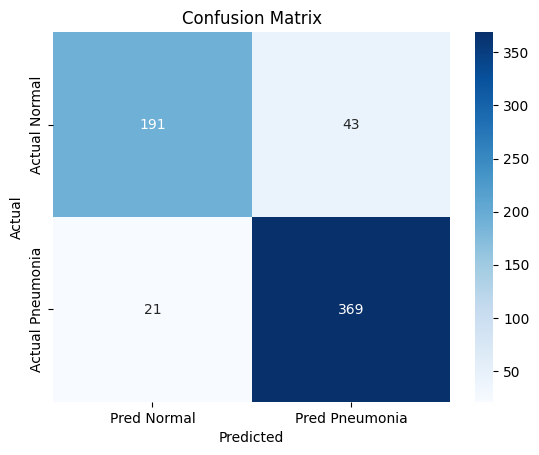

In [ ]:
# Confusion Matrix Visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Normal', 'Pred Pneumonia'],
            yticklabels=['Actual Normal', 'Actual Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**FIX THIS PARAGARPH BASED ON ABOVE RESULTS**

Overall, we can see that the baseline model did extremely well. The number of false positives and false negatives is relatively similar, but the recall of 0.94 and the strong F1 score show that the model is especially effective at correctly identifying pneumonia cases. This is very important in a medical context, since missing a pneumonia case (a false negative) is generally more harmful than incorrectly flagging a normal image. So, despite having frozen layers for a baseline, the model already demonstrates strong generalization. We have to note that our data is on the smaller end and as such, the baseline results may not fully be representative of how the model would perform on a larger population.

## Fine Tuning

Rather than tuning one hyperparameter at a time, we used a multi-dimensional (parallel) search. We first defined a small set of sensible values for each hyperparameter category (such as number of layers we unfreeze, learning rate, optimizer, regularization strength/dropout incoproration). Instead of testing every possible combination, we selected a curated subset of meaningful configurations based on deep learning best practices. This allowed us to jointly vary multiple hyperparameters at once while keeping the search computationally efficient and manageable. Our goal is to explore interactions between tuning decisions without performing a full exhaustive grid search.

Talk about how we also added early stopping for computational and other reasons

In [ ]:
# Helper functions


# 1) Loads baseline model - rebuilding the architecture we trained, but using a nested backbone so we can properly unfreeze the amount of layers we want
def load_baseline(path="/content/drive/MyDrive/Math_156_Project/best_resnet_baseline.h5"):
  base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

  x = base_model.output
  x = GlobalAveragePooling2D()(x)   # reduces spatial dims
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)               # regularization
  output = Dense(1, activation='sigmoid')(x)  # binary classification

  model = Model(inputs=base_model.input, outputs=output)

  # Save the base model as an attribute for easy access later
  model.base_model = base_model

  # load previous weights in that we already saved
  model.load_weights(path)

  return model


# 2) Dictates how many layers we are unfreezing
def unfreeze_layers(model, num_layers):
  base = model.base_model

  for layer in base.layers:
    layer.trainable = False

  for layer in base.layers[-num_layers:]:
    layer.trainable = True

  print(f"Unfroze last {num_layers} layers.")
  return model

# 3) Changes dropout rate
def adjust_dropout(model, new_rate):
  for layer in model.layers:
    if isinstance(layer, Dropout):
      layer.rate = new_rate
  return model

# 4) Changes l2 regularization usage
def apply_l2(model, l2_value):
  for layer in model.layers:
    if isinstance(layer, Dense):
      layer.kernel_regularizer = regularizers.l2(l2_value)
  print(f"Applied L2 regularization = {l2_value}")
  return model

# 5) changes all other combinations: optimizer, learning rate
def compile_model(model, learning_rate, optimizer_name):
  if optimizer_name == "adam":
    opt = Adam(learning_rate=learning_rate)
  elif optimizer_name == "sgd":
    opt = SGD(learning_rate=learning_rate, momentum=0.9)
  else:
    raise ValueError("Unknown optimizer")
  model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", Precision(), Recall()])
  return model

# 6) Function bringing them all together

def apply_config(model, config):

  # Unfreeze layers
  model = unfreeze_layers(model, config["unfreeze_layers"])

  # Adjust Dropout
  model = adjust_dropout(model, config["dropout"])

  # Apply L2 regularization
  if config["l2"] > 0:
    model = apply_l2(model, config["l2"])

  # Compile with chosen optimizer and learning rate
  model = compile_model(model, learning_rate=config["learning_rate"], optimizer_name=config["optimizer"])
  return model

  # NOTE: apply_l2() should run before compile_model() BUT only if dropout has been adjusted first


# 7) Evaluation

def run_experiment(config, train_gen, val_gen, test_gen, epochs=3):

  print("Configuration of parameters:", config)

  # Load fresh baseline each time
  model = load_baseline()

  # Apply config (unfreeze, dropout, L2, optimizer, lr)
  model = apply_config(model, config)

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True, verbose=1)

  # Train
  history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping], class_weight=class_weights, verbose=1)

  # Evaluate on validation set
  val_gen.reset()
  y_pred_probs = model.predict(val_gen)
  y_pred = (y_pred_probs > 0.5).astype(int).flatten()
  y_true = val_gen.classes

  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)

  print("\Validation Accuracy:", acc)
  print("Precision:", prec)
  print("Recall:", rec)
  print("F1:", f1)
  print("Confusion Matrix:\n", cm)

  return {
      "config": config,
      "accuracy": acc,
      "precision": prec,
      "recall": rec,
      "f1": f1,
      "confusion_matrix": cm
  }


# 8) Graphing the evaluation

def plot_results(df, x_col, metric_col):
  plt.figure(figsize=(8,5))
  plt.plot(df[x_col], df[metric_col], marker="o", linewidth=2)
  plt.xlabel(x_col.replace("_", " ").title(), fontsize=12)
  plt.ylabel(metric_col.replace("_", " ").title(), fontsize=12)
  plt.title(f"{metric_col.replace('_', ' ').title()} vs {x_col.replace('_', ' ').title()}", fontsize=14)
  plt.grid(True)
  plt.show()


<>:114: SyntaxWarning: invalid escape sequence '\V'
<>:114: SyntaxWarning: invalid escape sequence '\V'
/tmp/ipython-input-1259113723.py:114: SyntaxWarning: invalid escape sequence '\V'
  print("\Validation Accuracy:", acc)


In [ ]:
baseline_model = load_baseline()

In [ ]:
baseline_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

** ADD GRAPHS LATER BASED ON BIGGEST DIFFERENCE OF RESULTS **

Stage 1: Choosing depth (how many layers is best to unfreeze and relearn for test accuracy)?

In [ ]:
UNFREEZE_OPTIONS = [5, 10, 30]

results_phase1 = []

for depth in UNFREEZE_OPTIONS:

  config = {
      "unfreeze_layers": depth,
      "learning_rate": 1e-4,
      "optimizer": "adam",
      "dropout": 0.5,
      "l2": 0.0
    }

  print(f"\nRunning Phase 1 — depth = {depth}")

  metrics = run_experiment(config, train_generator, val_generator, test_generator, epochs = 3)

  results_phase1.append({"depth": depth, **metrics})

  results_phase1



Running Phase 1 — depth = 5
Configuration of parameters: {'unfreeze_layers': 5, 'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout': 0.5, 'l2': 0.0}
Unfroze last 5 layers.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 938ms/step - accuracy: 0.9615 - loss: 0.1047 - precision_1: 0.9883 - recall_1: 0.9600 - val_accuracy: 0.9684 - val_loss: 0.0910 - val_precision_1: 0.9921 - val_recall_1: 0.9652
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 837ms/step - accuracy: 0.9695 - loss: 0.0893 - precision_1: 0.9920 - recall_1: 0.9662 - val_accuracy: 0.9636 - val_loss: 0.1010 - val_precision_1: 0.9960 - val_recall_1: 0.9549
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 755ms/step
\Validation Accuracy: 0.9626794258373206
Precision: 0.9893758300132802
Recall: 0.9600515463917526
F1: 0.9744931327665141
Confusion Matrix:
 [[261   8]
 [ 31 745]]

Running Phase 1 — depth = 10
Configuration of parameters: {'unfreeze_layers': 10, 'learning_

Looking at the results, we decided that unfreezing the last 10 layers is the optimal setting for furhter fine-tuning. Although some depths showed very high validation accuracy during training, the restored best-epoch performance (based on F1 score, recall, and overall validation accuracy) showed that unfreezing too many layers led to unstable training and poorer generalization. Depth 10 consistently produced the strongest performance, with the highest F1 score, accuracy, and the most balanced confusion matrix. In contrast, our 5-layer model showed some signs of underiftting (smaller accuracy and recall), and our 30-layer model began to overfit.

Comparing it with the baseline:

In [ ]:
model = load_baseline()

val_generator.reset()

# --- Predict probabilities ---
y_pred_probs = model.predict(val_generator)

# Convert to labels
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = val_generator.classes

# --- Compute metrics ---
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("Baseline Evaluation:")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 757ms/step
Baseline Evaluation:
Validation Accuracy: 0.9550
Precision: 0.9919
Recall: 0.9472
F1 Score: 0.9690
Confusion Matrix:
[[263   6]
 [ 41 735]]


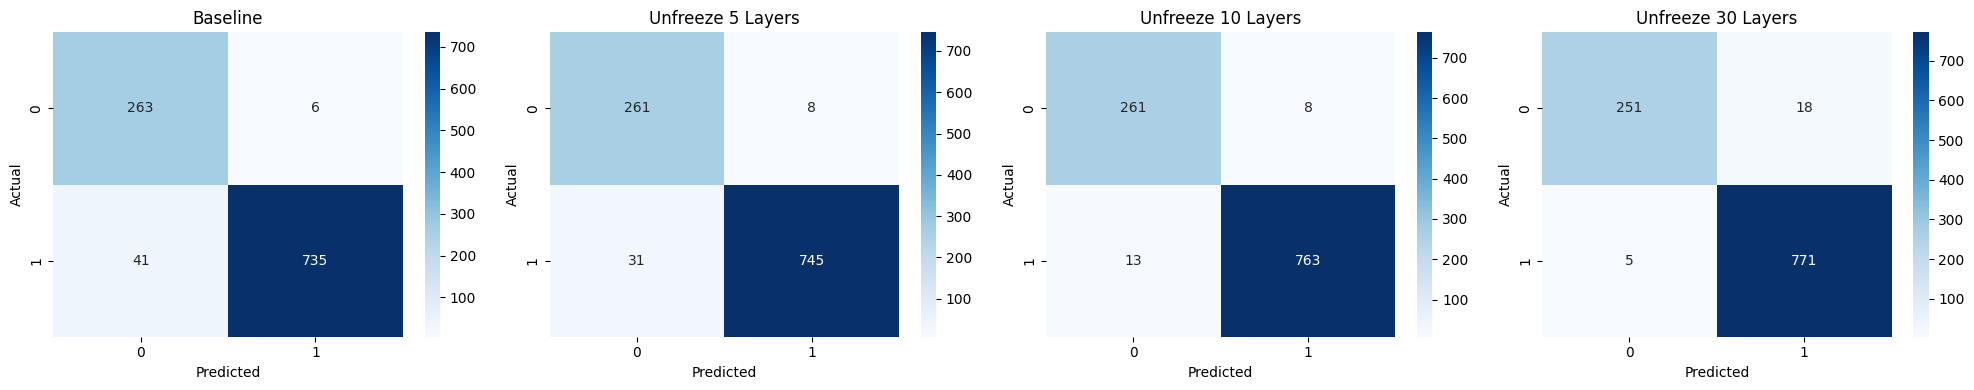

In [ ]:

# Confusion matrices
cm_baseline = np.array([[263, 6],
                        [41, 735]])

cm_5 = np.array([[261, 8],
                 [31, 745]])

cm_10 = np.array([[261, 8],
                  [13, 763]])

cm_30 = np.array([[251, 18],
                  [5, 771]])

cms = [cm_baseline, cm_5, cm_10, cm_30]
titles = ["Baseline", "Unfreeze 5 Layers", "Unfreeze 10 Layers", "Unfreeze 30 Layers"]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()



Stage 2: Learning Rate

In [ ]:
# Fix based on results
BEST_DEPTH = 10   # update after Phase 1

LR_OPTIONS = [1e-3, 1e-4, 1e-6]

results_phase2 = []

for lr in LR_OPTIONS:

    config = {
        "unfreeze_layers": BEST_DEPTH,
        "learning_rate": lr,
        "optimizer": "adam",
        "dropout": 0.5,
        "l2": 0.0
    }

    print(f"\nRunning Phase 2 — learning_rate = {lr}")

    metrics = run_experiment(config, train_generator, val_generator, test_generator, epochs = 3)

    results_phase2.append({"learning_rate": lr, **metrics})

results_phase2



Running Phase 2 — learning_rate = 0.001
Configuration of parameters: {'unfreeze_layers': 10, 'learning_rate': 0.001, 'optimizer': 'adam', 'dropout': 0.5, 'l2': 0.0}
Unfroze last 10 layers.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 938ms/step - accuracy: 0.9235 - loss: 0.2903 - precision_4: 0.9759 - recall_4: 0.9219 - val_accuracy: 0.9512 - val_loss: 0.1993 - val_precision_4: 0.9959 - val_recall_4: 0.9381
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 840ms/step - accuracy: 0.9602 - loss: 0.1064 - precision_4: 0.9894 - recall_4: 0.9572 - val_accuracy: 0.9598 - val_loss: 0.1463 - val_precision_4: 0.9520 - val_recall_4: 0.9961
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 845ms/step - accuracy: 0.9669 - loss: 0.0891 - precision_4: 0.9909 - recall_4: 0.9644 - val_accuracy: 0.9684 - val_loss: 0.0732 - val_precision_4: 0.9947 - val_recall_4: 0.9626
Restoring model weights from the end of the best epoch: 3.
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 752ms/step
\Validation Accuracy: 0.9732057416267943
Preci

[{'learning_rate': 0.001,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.001,
   'optimizer': 'adam',
   'dropout': 0.5,
   'l2': 0.0},
  'accuracy': 0.9732057416267943,
  'precision': 0.9973404255319149,
  'recall': 0.9664948453608248,
  'f1': 0.981675392670157,
  'confusion_matrix': array([[267,   2],
         [ 26, 750]])},
 {'learning_rate': 0.0001,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'adam',
   'dropout': 0.5,
   'l2': 0.0},
  'accuracy': 0.9741626794258373,
  'precision': 0.9947159841479525,
  'recall': 0.970360824742268,
  'f1': 0.9823874755381604,
  'confusion_matrix': array([[265,   4],
         [ 23, 753]])},
 {'learning_rate': 1e-06,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 1e-06,
   'optimizer': 'adam',
   'dropout': 0.5,
   'l2': 0.0},
  'accuracy': 0.9598086124401913,
  'precision': 0.9946091644204852,
  'recall': 0.9510309278350515,
  'f1': 0.9723320158102767,
  'confusion_matrix': array([[265,   4],
 

Out of the chosen learning rates, 1e-4 was the optimal fine-tuning learning rate. A larger learning rate of 1e-3 caused the model to predict the pneumonia class for all images, achieving perfect recall but zero ability to identify normal cases. This shows that it doesn't have discriminative power. On the other hand, a much smaller learning rate rate of 1e-6 failed to update the backbone meaningfully, which lead to very poor accuracy and extremely low recal (showing the model was underfitting). The learning rate of 1e-4 provided the best balance, maintaining stable training while improving the model’s ability to correctly identify both classes.

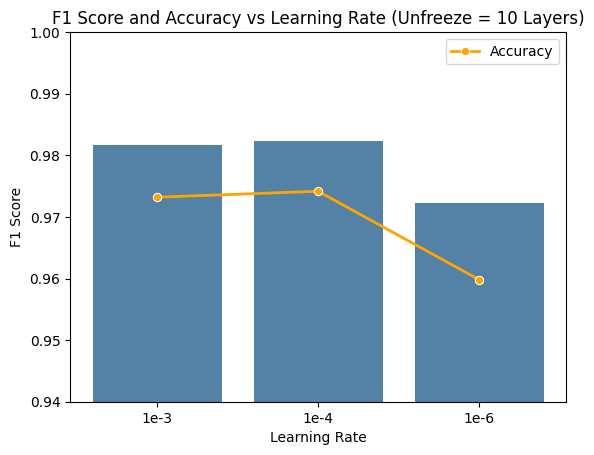

In [ ]:
# graph
data_lr = pd.DataFrame({
    "Learning Rate": ["1e-3", "1e-4", "1e-6"],
    "F1 Score": [0.981675, 0.982387, 0.972332],
    "Accuracy": [0.9732057416267943, 0.9741626794258373, 0.959808612440191]
})

# F1 : bars
sns.barplot(data=data_lr, x="Learning Rate", y="F1 Score", color="steelblue")

# Accuracy: line
sns.lineplot(data=data_lr, x="Learning Rate", y="Accuracy",
             marker="o", linewidth=2, color="orange", label=" Validation Accuracy")

plt.ylim(0.94, 1.00)
plt.title("F1 Score and Accuracy vs Learning Rate (Unfreeze = 10 Layers)")
plt.legend()
plt.show()

Stage 3: Different optimizers

In [ ]:
# Fix based on results

# FIX THIS CODE TO INCLUDE DIFF MOMENTUMS
BEST_DEPTH = 10
BEST_LR = 1e-4

OPTIMIZER_OPTIONS = ["adam", "sgd"]

results_phase3 = []

for opt in OPTIMIZER_OPTIONS:

    config = {
        "unfreeze_layers": BEST_DEPTH,
        "learning_rate": BEST_LR,
        "optimizer": opt,
        "dropout": 0.5,
        "l2": 0.0
    }

    print(f"\nRunning Phase 3 — optimizer = {opt}")

    metrics = run_experiment(config, train_generator, val_generator, test_generator, epochs = 3)

    results_phase3.append({"optimizer": opt, **metrics})

results_phase3



Running Phase 3 — optimizer = adam
Configuration of parameters: {'unfreeze_layers': 10, 'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout': 0.5, 'l2': 0.0}
Unfroze last 10 layers.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 933ms/step - accuracy: 0.9530 - loss: 0.1228 - precision_7: 0.9865 - recall_7: 0.9479 - val_accuracy: 0.9799 - val_loss: 0.0563 - val_precision_7: 0.9922 - val_recall_7: 0.9807
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 838ms/step - accuracy: 0.9734 - loss: 0.0615 - precision_7: 0.9924 - recall_7: 0.9715 - val_accuracy: 0.9703 - val_loss: 0.0717 - val_precision_7: 0.9831 - val_recall_7: 0.9768
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 756ms/step
\Validation Accuracy: 0.9799043062200957
Precision: 0.9947575360419397
Recall: 0.9780927835051546
F1: 0.98635477582846
Confusion Matrix:
 [[265   4]
 [ 17 759]]

Running Phase 3 — optimizer = sgd
Configuration of parameters: {'unfreeze_layers': 10

[{'optimizer': 'adam',
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'adam',
   'dropout': 0.5,
   'l2': 0.0},
  'accuracy': 0.9799043062200957,
  'precision': 0.9947575360419397,
  'recall': 0.9780927835051546,
  'f1': 0.98635477582846,
  'confusion_matrix': array([[265,   4],
         [ 17, 759]])},
 {'optimizer': 'sgd',
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'sgd',
   'dropout': 0.5,
   'l2': 0.0},
  'accuracy': 0.9569377990430622,
  'precision': 0.9945872801082544,
  'recall': 0.9471649484536082,
  'f1': 0.9702970297029703,
  'confusion_matrix': array([[265,   4],
         [ 41, 735]])}]

SGD momentum was way worse than ADAM - keeping ADAM

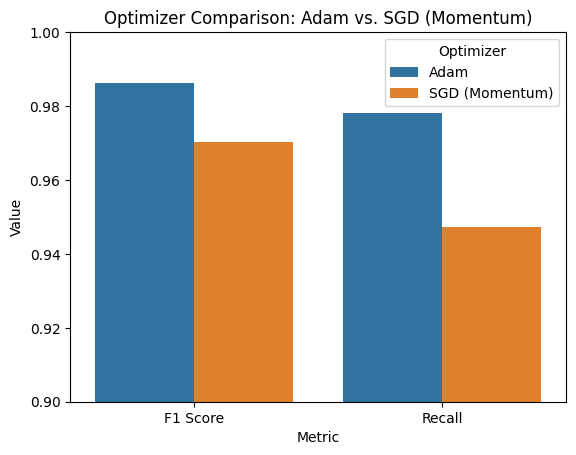

In [ ]:
data_opt = pd.DataFrame({
    "Optimizer": ["Adam", "SGD (Momentum)"],
    "F1 Score": [0.986355, 0.970297],
    "Recall": [0.978093, 0.947165]
})

data_opt_melt = data_opt.melt(
    id_vars="Optimizer",
    value_vars=["F1 Score", "Recall"],
    var_name="Metric",
    value_name="Value"
)

sns.barplot(
    data=data_opt_melt,
    x="Metric",
    y="Value",
    hue="Optimizer"
)

plt.title("Optimizer Comparison: Adam vs. SGD (Momentum)")
plt.ylim(0.90, 1.00)
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Optimizer")
plt.show()


Stage 4: Different dropouts

In [ ]:
# Fix based on results
BEST_DEPTH = 10
BEST_LR = 1e-4
BEST_OPT = "adam"

DROPOUT_OPTIONS = [0.0, 0.3, 0.5]

results_phase4 = []

for dr in DROPOUT_OPTIONS:

    config = {
        "unfreeze_layers": BEST_DEPTH,
        "learning_rate": BEST_LR,
        "optimizer": BEST_OPT,
        "dropout": dr,
        "l2": 0.0
    }

    print(f"\nRunning Phase 4 — dropout = {dr}")

    metrics = run_experiment(config, train_generator, val_generator, test_generator, epochs = 3)

    results_phase4.append({"dropout": dr, **metrics})

results_phase4



Running Phase 4 — dropout = 0.0
Configuration of parameters: {'unfreeze_layers': 10, 'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout': 0.0, 'l2': 0.0}
Unfroze last 10 layers.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 935ms/step - accuracy: 0.9660 - loss: 0.0832 - precision_9: 0.9922 - recall_9: 0.9618 - val_accuracy: 0.9713 - val_loss: 0.0687 - val_precision_9: 0.9908 - val_recall_9: 0.9704
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 849ms/step - accuracy: 0.9713 - loss: 0.0715 - precision_9: 0.9923 - recall_9: 0.9684 - val_accuracy: 0.9761 - val_loss: 0.0835 - val_precision_9: 0.9947 - val_recall_9: 0.9729
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 849ms/step - accuracy: 0.9806 - loss: 0.0488 - precision_9: 0.9962 - recall_9: 0.9778 - val_accuracy: 0.9598 - val_loss: 0.1194 - val_precision_9: 0.9959 - val_recall_9: 0.9497
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 755ms/step
\Validation Accuracy: 0.97320

[{'dropout': 0.0,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'adam',
   'dropout': 0.0,
   'l2': 0.0},
  'accuracy': 0.9732057416267943,
  'precision': 0.9947089947089947,
  'recall': 0.9690721649484536,
  'f1': 0.9817232375979112,
  'confusion_matrix': array([[265,   4],
         [ 24, 752]])},
 {'dropout': 0.3,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'adam',
   'dropout': 0.3,
   'l2': 0.0},
  'accuracy': 0.9732057416267943,
  'precision': 0.9934036939313984,
  'recall': 0.970360824742268,
  'f1': 0.9817470664928292,
  'confusion_matrix': array([[264,   5],
         [ 23, 753]])},
 {'dropout': 0.5,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'adam',
   'dropout': 0.5,
   'l2': 0.0},
  'accuracy': 0.9741626794258373,
  'precision': 0.983225806451613,
  'recall': 0.9819587628865979,
  'f1': 0.9825918762088974,
  'confusion_matrix': array([[256,  13],
         [ 14, 762]])}]

.3: higher f1-score and accuracy

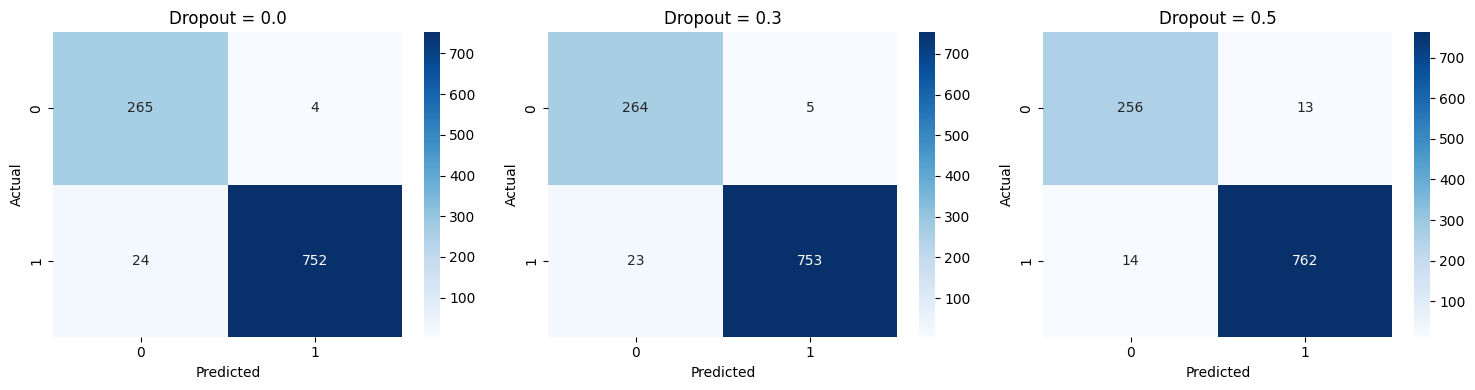

In [ ]:
cm_00 = np.array([[265, 4],
                  [24, 752]])

cm_03 = np.array([[264, 5],
                  [23, 753]])

cm_05 = np.array([[256, 13],
                  [14, 762]])

cms = [cm_00, cm_03, cm_05]
titles = ["Dropout = 0.0", "Dropout = 0.3", "Dropout = 0.5"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()

Stage 5: L2 regularization tuning

In [ ]:
# Fix based on results
BEST_DEPTH = 10
BEST_LR = 1e-4
BEST_OPT = "adam"
BEST_DROPOUT = 0.3

L2_OPTIONS = [0.0, 0.01, 0.1]

results_phase5 = []

for l2val in L2_OPTIONS:

    config = {
        "unfreeze_layers": BEST_DEPTH,
        "learning_rate": BEST_LR,
        "optimizer": BEST_OPT,
        "dropout": BEST_DROPOUT,
        "l2": l2val
    }

    print(f"\nRunning Phase 5 — L2 = {l2val}")



    metrics = run_experiment(config, train_generator, val_generator, test_generator, epochs = 3)

    results_phase5.append({"l2": l2val, **metrics})

results_phase5



Running Phase 5 — L2 = 0.0
Configuration of parameters: {'unfreeze_layers': 10, 'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout': 0.3, 'l2': 0.0}
Unfroze last 10 layers.
Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 940ms/step - accuracy: 0.9600 - loss: 0.0968 - precision_12: 0.9895 - recall_12: 0.9562 - val_accuracy: 0.9713 - val_loss: 0.0790 - val_precision_12: 0.9770 - val_recall_12: 0.9845
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 846ms/step - accuracy: 0.9730 - loss: 0.0684 - precision_12: 0.9949 - recall_12: 0.9685 - val_accuracy: 0.9751 - val_loss: 0.0673 - val_precision_12: 0.9883 - val_recall_12: 0.9781
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 840ms/step - accuracy: 0.9815 - loss: 0.0493 - precision_12: 0.9947 - recall_12: 0.9805 - val_accuracy: 0.9713 - val_loss: 0.0702 - val_precision_12: 0.9857 - val_recall_12: 0.9755
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 755ms/step
\Validation Accuracy: 

[{'l2': 0.0,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'adam',
   'dropout': 0.3,
   'l2': 0.0},
  'accuracy': 0.9760765550239234,
  'precision': 0.9934296977660972,
  'recall': 0.9742268041237113,
  'f1': 0.9837345478204295,
  'confusion_matrix': array([[264,   5],
         [ 20, 756]])},
 {'l2': 0.01,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'adam',
   'dropout': 0.3,
   'l2': 0.01},
  'accuracy': 0.9712918660287081,
  'precision': 0.9782051282051282,
  'recall': 0.9832474226804123,
  'f1': 0.980719794344473,
  'confusion_matrix': array([[252,  17],
         [ 13, 763]])},
 {'l2': 0.1,
  'config': {'unfreeze_layers': 10,
   'learning_rate': 0.0001,
   'optimizer': 'adam',
   'dropout': 0.3,
   'l2': 0.1},
  'accuracy': 0.9741626794258373,
  'precision': 0.9795134443021767,
  'recall': 0.9858247422680413,
  'f1': 0.9826589595375722,
  'confusion_matrix': array([[253,  16],
         [ 11, 765]])}]

.01 was the best

Evaluating chosen model

In [ ]:
final_model = load_baseline("/content/drive/MyDrive/Math_156_Project/best_resnet_baseline.h5")

final_config = {
    "unfreeze_layers": 10,
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "dropout": 0.3,
    "l2": 0.01
}

final_model = apply_config(final_model, final_config)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Math_156_Project/final_best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history_final = final_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,         # let early stopping decide
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights,
    verbose=1
)

Unfroze last 10 layers.
Applied L2 regularization = 0.01
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9702 - loss: 0.0933 - precision_15: 0.9892 - recall_15: 0.9708
Epoch 1: val_loss improved from inf to 0.07589, saving model to /content/drive/MyDrive/Math_156_Project/final_best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 144s 990ms/step - accuracy: 0.9702 - loss: 0.0933 - precision_15: 0.9892 - recall_15: 0.9707 - val_accuracy: 0.9694 - val_loss: 0.0759 - val_precision_15: 0.9934 - val_recall_15: 0.9652 - learning_rate: 1.0000e-04
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9740 - loss: 0.0654 - precision_15: 0.9927 - recall_15: 0.9726
Epoch 2: val_loss improved from 0.07589 to 0.05691, saving model to /content/drive/MyDrive/Math_156_Project/final_best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 115s 878ms/step - accuracy: 0.9740 - loss: 0.0654 - precision_15: 0.9927 - recall_15: 0.9726 - val_accuracy: 0.9770 - val_loss: 0.0569 - val_precision_15: 0.9896 - val_recall_15: 0.9794 - learning_rate: 1.0000e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9806 - loss: 0.0499 - precision_15: 0.9965 - recall_15: 0.9772
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 3: val_loss did not improve from 0.05691
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 850ms/step - accuracy: 0.9806 - loss: 0.0499 - precision_15: 0.9965 - recall_15: 0.9772 - val_accuracy: 0.9713 - val_loss: 0.0833 - val_precision_15: 0.9987 - val_recall_15: 0.9626 - learning_rate: 1.0000e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9828 - loss: 0.0447 - precision_15: 0.9971 - recall_15: 0.9798
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 4: val_loss did not improve from 0.05691
131

131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 856ms/step - accuracy: 0.9849 - loss: 0.0343 - precision_15: 0.9972 - recall_15: 0.9821 - val_accuracy: 0.9732 - val_loss: 0.0562 - val_precision_15: 0.9960 - val_recall_15: 0.9678 - learning_rate: 4.0000e-06
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9849 - loss: 0.0384 - precision_15: 0.9964 - recall_15: 0.9832
Epoch 6: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 6: val_loss did not improve from 0.05619
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 856ms/step - accuracy: 0.9849 - loss: 0.0384 - precision_15: 0.9964 - recall_15: 0.9832 - val_accuracy: 0.9722 - val_loss: 0.0725 - val_precision_15: 0.9987 - val_recall_15: 0.9639 - learning_rate: 4.0000e-06
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.9878 - loss: 0.0259 - precision_15: 0.9983 - recall_15: 0.9853
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.

Epoch 7: val_loss improved from 0.05619 to 0.05610,

131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 860ms/step - accuracy: 0.9878 - loss: 0.0259 - precision_15: 0.9983 - recall_15: 0.9853 - val_accuracy: 0.9799 - val_loss: 0.0561 - val_precision_15: 0.9961 - val_recall_15: 0.9768 - learning_rate: 8.0000e-07
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9878 - loss: 0.0287 - precision_15: 0.9979 - recall_15: 0.9855
Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 8: val_loss did not improve from 0.05610
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 852ms/step - accuracy: 0.9878 - loss: 0.0287 - precision_15: 0.9979 - recall_15: 0.9855 - val_accuracy: 0.9751 - val_loss: 0.0621 - val_precision_15: 0.9947 - val_recall_15: 0.9716 - learning_rate: 1.6000e-07
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.9861 - loss: 0.0333 - precision_15: 0.9983 - recall_15: 0.9832
Epoch 9: val_loss did not improve from 0.05610
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 840ms/step - accuracy: 0.9862 - loss: 0.0333 - precision_15: 0.

In [ ]:
test_loss, test_acc, test_prec, test_rec = final_model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Reset generator (important to avoid ordering issues)
test_generator.reset()

# Get predicted probabilities
y_pred_probs = final_model.predict(test_generator)

# Convert probabilities -> class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# True labels from generator
y_true = test_generator.classes

f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.8852 - loss: 0.3493 - precision_15: 0.5316 - recall_15: 0.6365
Test Accuracy: 0.9103
Test Precision: 0.9113
Test Recall: 0.9487
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 495ms/step
F1 Score: 0.9296482412060302
Confusion Matrix:
[[198  36]
 [ 20 370]]


<!-- Although fine-tuning, in general, improves CNN performance, our results showed the opposite: the frozen-backbone baseline outperformed our fine-tuned variant. Even after experimenting with unfreezing different depths, learning rates, optimizers, dropout, and L2 regularization, we were unable to get a higher accuracy than the test set. Instead, fine-tuning seemed to have increased overfitting. We can see this by the drop in our preicision, and increasing the amount of false positives we have, despite having extremely high recall. This is most likely due to issues with our dataset. Since our dataset is fairly small and already highly imbalanced, the ImageNet-trained ResNet50 features are often already strong enough to generalize. As such, updating even a few backbone layers can cause the network to memorize subtle noise patterns rather than learning generalizable pneumonia-specific features. We attempted to mitigate this using class weights and augmentation, as well as adding in early stopping, our model still tended to overfit as soon as the backbone was unfrozen. Ultimately, our findings show that with small and highly imbalanced medical datasets, a frozen pretrained model can generalize better than a fine-tuned one, and further tuning can harm performance rather than improve it. -->

Maia Code

In [ ]:
# Unfreeze top layers of ResNet50
# Recompile the model for the trainable changes to take effect
# Goal: Let the pretrained ResNet50 backbone learn X-ray-specific features

# base_model = model.get_layer('resnet50')
# base_model = model.layers([1])

for layer in base_model.layers[-30:]:
    layer.trainable = True

print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers in base model: {sum([1 for layer in base_model.layers if layer.trainable])}")

Total layers in base model: 175
Trainable layers in base model: 30


In [ ]:
# Define early stopping callback

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Recompile for fine-tuning

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history_1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9262 - loss: 0.1963 - precision_16: 0.9667 - recall_16: 0.9338 - val_accuracy: 0.9656 - val_loss: 0.0910 - val_precision_16: 0.9660 - val_recall_16: 0.9884
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 842ms/step - accuracy: 0.9687 - loss: 0.0910 - precision_16: 0.9789 - recall_16: 0.9790 - val_accuracy: 0.9694 - val_loss: 0.0862 - val_precision_16: 0.9806 - val_recall_16: 0.9781
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 839ms/step - accuracy: 0.9775 - loss: 0.0585 - precision_16: 0.9857 - recall_16: 0.9842 - val_accuracy: 0.9761 - val_loss: 0.0734 - val_precision_16: 0.9796 - val_recall_16: 0.9884
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 835ms/step - accuracy: 0.9820 - loss: 0.0492 - precision_16: 0.9876 - recall_16: 0.9882 - val_accuracy: 0.9837 - val_loss: 0.0496 - val_precision_16: 0.9897 - val_recall_16: 0.9884
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 837ms/step - accuracy: 0.9819 - loss: 0.0474 - precisi

In [ ]:
# SGD with momentum

model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history_2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping])

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9913 - loss: 0.0269 - precision_17: 0.9965 - recall_17: 0.9920 - val_accuracy: 0.9847 - val_loss: 0.0421 - val_precision_17: 0.9935 - val_recall_17: 0.9858
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 838ms/step - accuracy: 0.9880 - loss: 0.0346 - precision_17: 0.9916 - recall_17: 0.9922 - val_accuracy: 0.9837 - val_loss: 0.0472 - val_precision_17: 0.9834 - val_recall_17: 0.9948
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 848ms/step - accuracy: 0.9914 - loss: 0.0274 - precision_17: 0.9922 - recall_17: 0.9963 - val_accuracy: 0.9837 - val_loss: 0.0439 - val_precision_17: 0.9948 - val_recall_17: 0.9832
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 840ms/step - accuracy: 0.9884 - loss: 0.0312 - precision_17: 0.9901 - recall_17: 0.9941 - val_accuracy: 0.9809 - val_loss: 0.0503 - val_precision_17: 0.9948 - val_recall_17: 0.9794
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 838ms/step - accuracy: 0.9900 - loss: 0.0303 - precisi

In [ ]:
# Adam with L2 regularization


base_model_reg = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_reg.layers[-30:]:
    layer.trainable = True

x = base_model_reg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

model_reg = Model(inputs=base_model_reg.input, outputs=predictions)

model_reg.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history_3 = model_reg.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 180s 991ms/step - accuracy: 0.7519 - loss: 2.9094 - precision_18: 0.8920 - recall_18: 0.7489 - val_accuracy: 0.8957 - val_loss: 2.5832 - val_precision_18: 0.8820 - val_recall_18: 0.9923
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 781ms/step - accuracy: 0.9552 - loss: 2.5047 - precision_18: 0.9672 - recall_18: 0.9729 - val_accuracy: 0.9100 - val_loss: 2.5129 - val_precision_18: 0.8929 - val_recall_18: 0.9987
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 779ms/step - accuracy: 0.9557 - loss: 2.4284 - precision_18: 0.9653 - recall_18: 0.9747 - val_accuracy: 0.9215 - val_loss: 2.4354 - val_precision_18: 0.9073 - val_recall_18: 0.9961
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 787ms/step - accuracy: 0.9671 - loss: 2.3305 - precision_18: 0.9736 - recall_18: 0.9820 - val_accuracy: 0.9694 - val_loss: 2.2828 - val_precision_18: 0.9662 - val_recall_18: 0.9936
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 778ms/step - accuracy: 0.9771 - loss: 2.2493 - prec

In [ ]:

test_generator.reset()
y_pred_probs = model_reg.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

In [ ]:

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")